In [17]:
## Import packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the csv into a dataframe

In [18]:
## Importing the csv into a dataframe 
nba_df = pd.read_csv('/Users/krist/Downloads/nba_df.csv')
nba_df.head()

,Season,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Position
0,2003,Tariq Abdul-Wahad,SG,28,DAL,14,0,14.6,1.9,4.1,...,NaN,0.2,0.2,0.4,0.104,-1.6,0.2,-1.4,0.0,SG
1,2003,Shareef Abdur-Rahim,PF,26,ATL,81,81,38.1,7.0,14.6,...,NaN,7.4,2.3,9.7,0.151,2.3,-0.7,1.6,2.8,PF
2,2003,Courtney Alexander,PG,25,NOH,66,7,20.6,2.9,7.7,...,NaN,0.1,1.0,1.1,0.040,-3.3,-1.2,-4.5,-0.9,PG
3,2003,Malik Allen,PF,24,MIA,80,73,29.0,4.2,9.9,...,NaN,-1.7,2.6,0.9,0.018,-3.9,-0.4,-4.4,-1.4,PF
4,2003,Ray Allen*,SG,27,TOT,76,75,37.9,7.9,17.9,...,NaN,7.6,1.5,9.1,0.152,4.7,-1.0,3.6,4.1,SG


## Data cleaning
### Dealing with players with multiple positions 
We notice that some players list multiple positions, for example: 'PG-SG'
I chose to deal with this issue by assigning a single position to each of these players which corresponds to the leftmost position listed (the position preceding the '-' sign). That way, we can conduct positional segmentation without having too many categories which would make the visualization significantly less readable
### Turning statistical columns into numeric data types
We will want to conduct statistical operations (sums, averages, etc.) on the statistical columns so it is important to turn them into numeric datatypes before proceeding. 
### Filtering for the 2022 NBA season
I want to start my analysis of the basketball dataset by focusing on a single full NBA season. The 2022 season is the most recent complete season we have at our disposal so I will focus on it to create my initial analyses. 
### Getting abridged player names 
This makes it easier to visualize names in figures, especially when we want to plot the names of the players on the chart itself (for example when plotting the top players on a scatter plot, it is more visually appealing for the viewer to see the player's name right next to the data point) 


In [19]:
# Counting the number of unique position values to find out why there are 17 different ones 

position_array = pd.unique(nba_df['Pos'])

# finding the positions that we want to filter the dataset for: 

multi_pos = []
for i in position_array: 
    if i.find('-') != -1:
        multi_pos.append(i)
                
weird_pos = nba_df[nba_df['Pos'].isin(multi_pos)].groupby('Pos')['Player'].count().sort_values(ascending=False)
weird_pos = weird_pos.index[:]

# Algorithm to change the position of a player who lists multiple positions

nba_df['Position'] = nba_df.apply(lambda x: x['Pos'][:x['Pos'].find('-')] if x['Pos'] in weird_pos else x['Pos'], axis=1)
nba_df_final = nba_df.drop(labels='Pos',axis=1)

# Changing the statistical columns into numeric data types 
cols = nba_df_final.columns.drop(['Player','Position','Tm'])
nba_df_final[cols] = nba_df_final[cols].apply(pd.to_numeric)

# Filtering the data to only look at stats from the 2022 NBA season as a start
nba_22 = nba_df_final[nba_df_final['Season'] == 2022]

# Getting abridged player names by only showing their last name 
nba_22['Player'] = nba_22.apply(lambda x: x['Player'][x['Player'].find(' '):],axis=1)


C:\Users\krist\AppData\Local\Temp\ipykernel_13148\3721244120.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['Player'] = nba_22.apply(lambda x: x['Player'][x['Player'].find(' '):],axis=1)


## Statistical overview of the season : Univariate distribution analysis 
### Objective
The objective here is to look at the distribution of certain key statistics (elaborated on below) in order to see if there are anomalies (eg. a distribution which has a significant skew) which would allow us to draw potentially interesting insights
### Choosing certain statistics 
Because there are 52 columns in the scraped dataset, I choose to inspect the distribution of a subset. The subset you see below (in the variable 'cols') have been chosen because it gives me a big picture overview of major performance areas while being relatively lightweight.

### Visualization choice 
I have chosen to plot each feature on a histogram in order to inspect its distribution (mean, dispersion) and draw insights
### Insights drawn
<ol>
    <li>There are a lot of young players (biggest bucket is the 24-25 year range)
    <li>The average player plays around 20 minutes per game 
    <li>The average player shoots around 45% from the field (FG%)
    <li>The average player shoots around 36% from the 3-point (3P%) but there is a big bucket of players who shoot 0%. They are probably the PF/C who play close to the rim  
    <li>Passing, rebounding and scoring are right-skewed and the average player has a 10/2/2 split (PTS/AST/TRB)
    <li>The average player is involved in around 17% of the team's possessions (looking at USG%)    
        
   

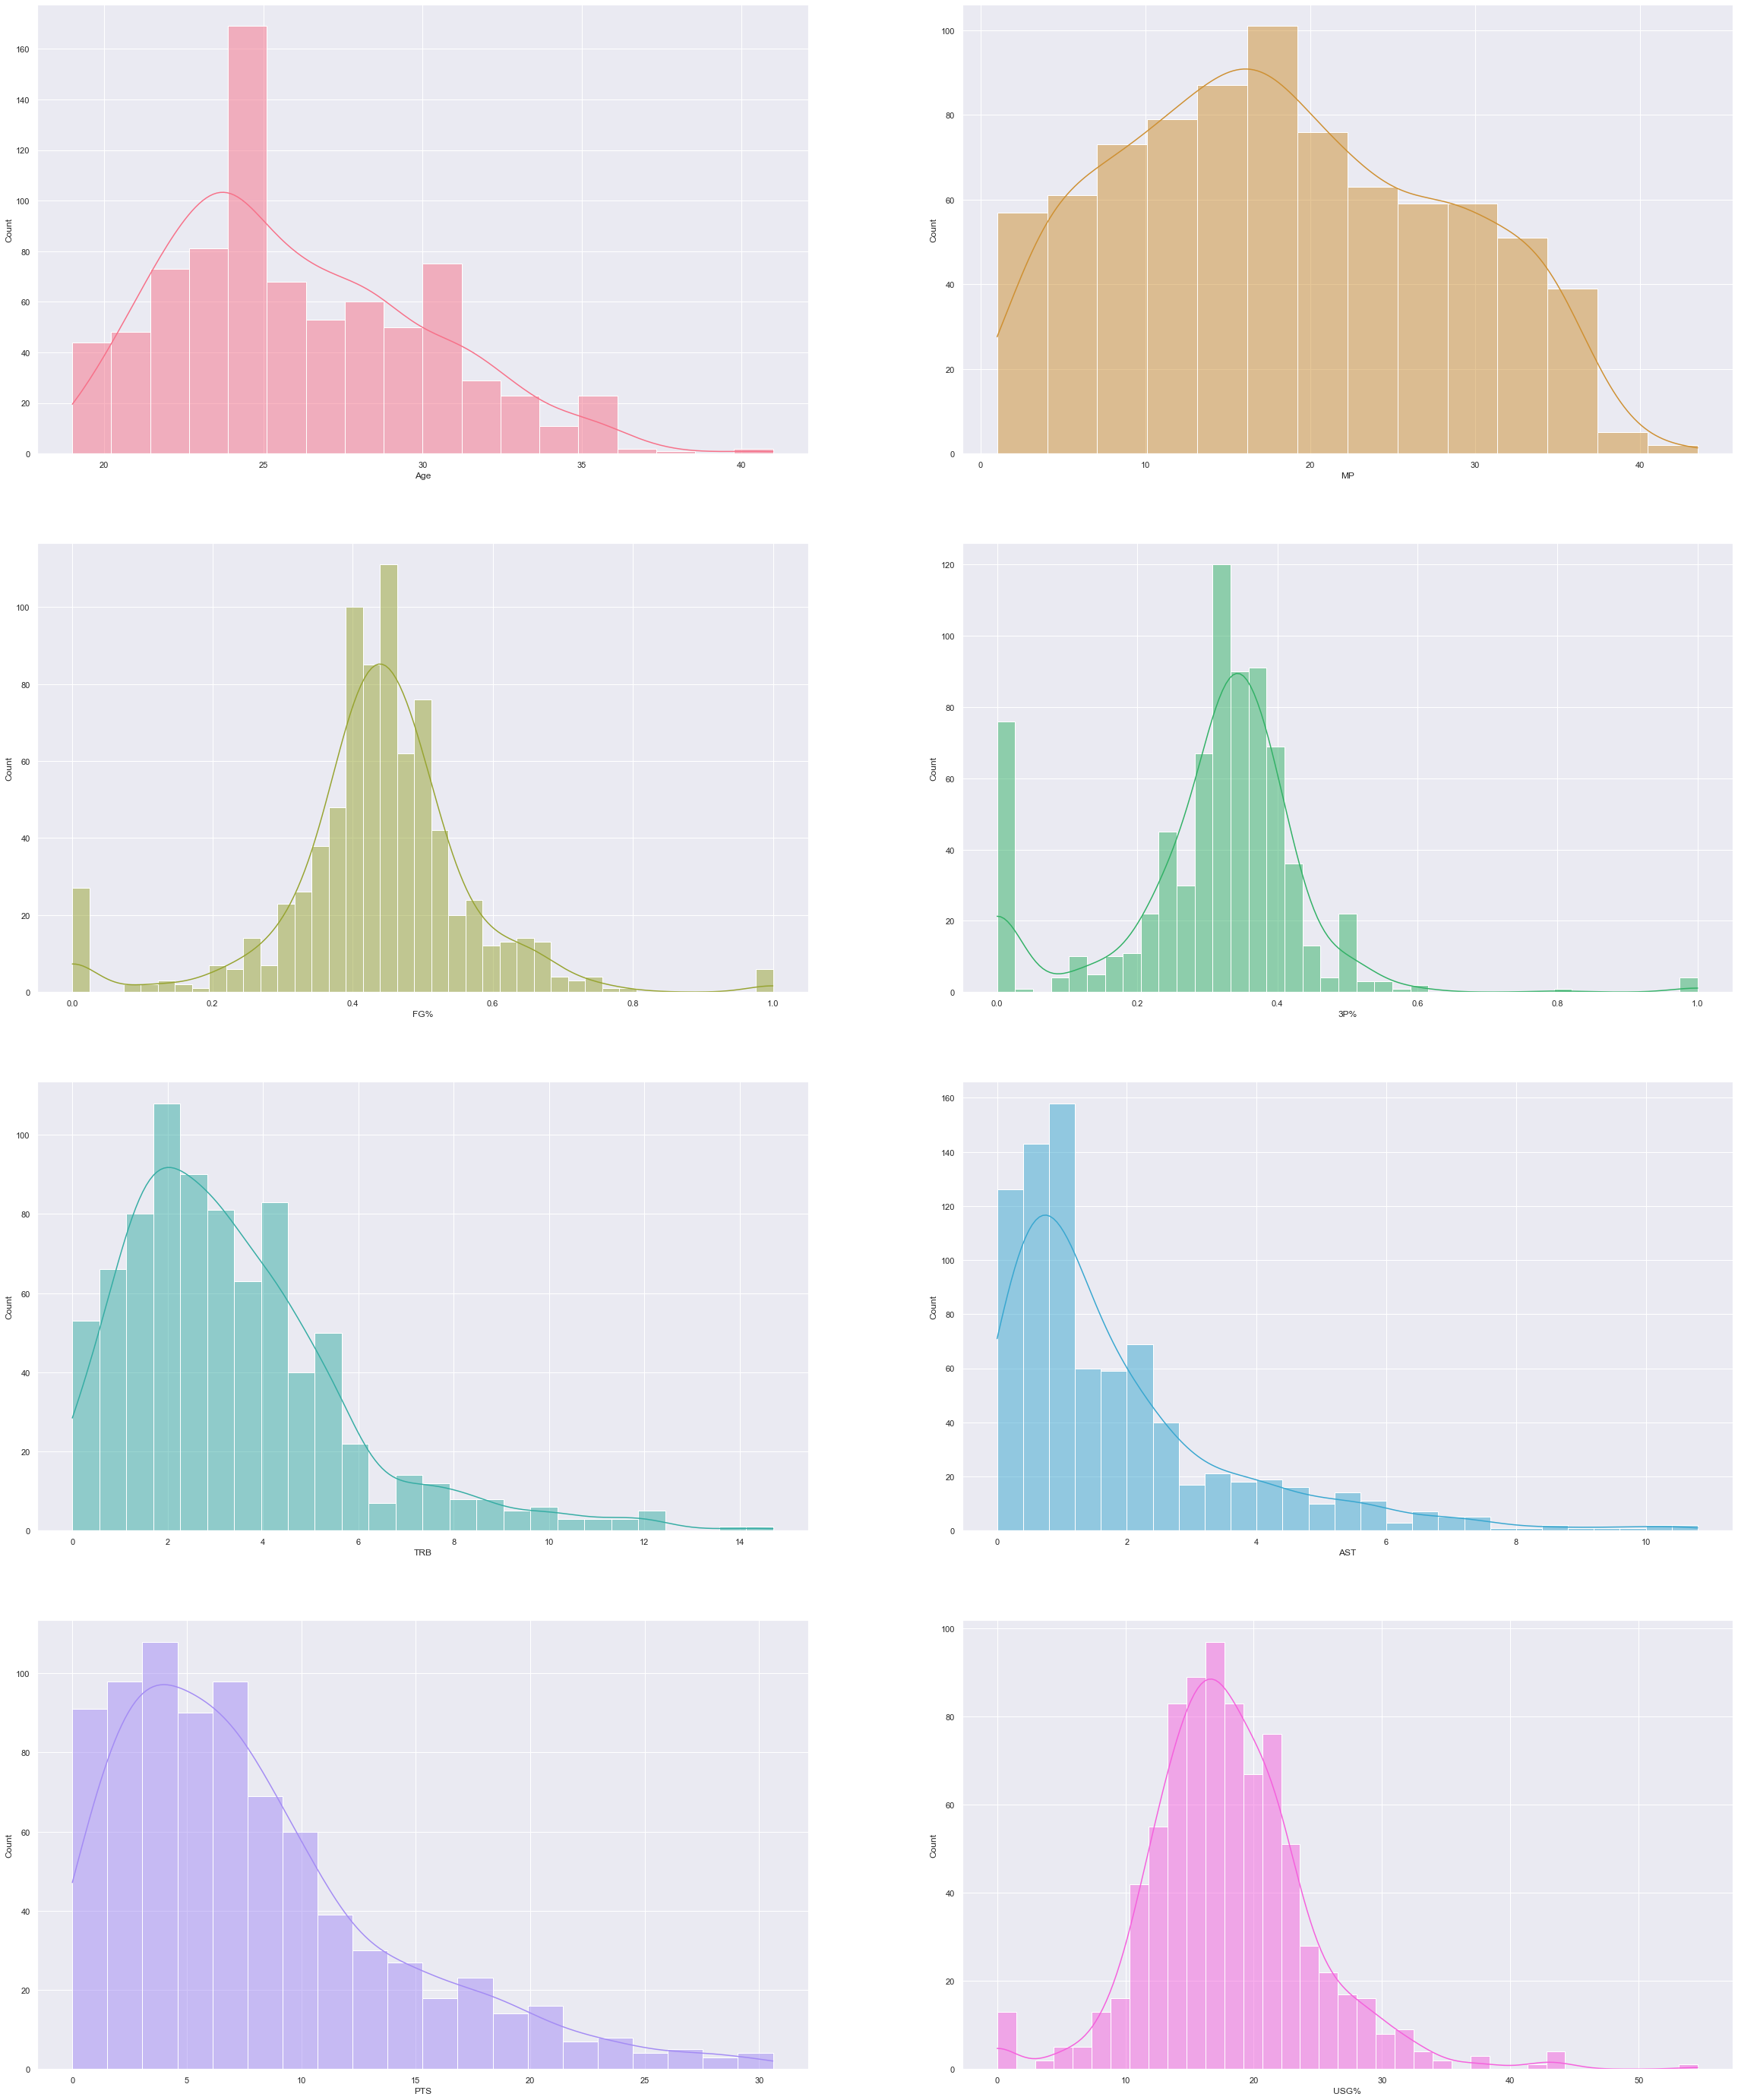

In [20]:
## Analysis 1 : General data overview and trying to uncover interesting patterns

# Choosing the columns/features which will be plotted  
cols = ['Age','MP','FG%', '3P%', 'TRB', 'AST', 'PTS', 'USG%']
palette = sns.color_palette('husl', len(cols))
sns.set(style="darkgrid")

fig, axs = plt.subplots(4, 2, figsize=(40, 50))

# Creating a loop to plot all of the chosen statistics 

def col_fct(i): 
    if i%2 == 0: 
        return 0
    else: 
        return 1

def row_fct(i):  
    if i in [0,1]:
        return 0
    else:
        if i%2 ==0: return int(i/2)
        else: return int(i/2-0.5 )
        
for i in range(len(cols)): 
    sns.histplot(data=nba_22, x=cols[i], kde=True, color=palette[i], ax=axs[row_fct(i), col_fct(i)])

## Statistical overview of the season: Multivariate analysis using a correlation heatmap 

### Objective
The objective is to find interesting relationships between different columns in the dataset 
### Certain interesting insights drawn
<ol>
    <li>Strong correlation between 2P% and PER (an aggregate efficiency metric) and higher than that between 3P% and PER
    <li>Effective FG% is strongly correlated with certain efficiency metrics (BPM and PER) while having weak correlation with others (VORP and WS)
    <li>There is an interesting relationship between free throw attempts and 3P attempts (44% correlation). While it is not super significant, it is interesting to note    
    <li>Rebounds have a strong correlation (66%) with free throw attempts, meaning a lot of rebounds come from missed free throws 
    <li>Assists have a fairly low correlation (under 60%) with all aggregate efficiency metrics (PER, BPM, WS, VORP) 
    <li>PER is highly correlated with BPM (91%) while having weak correlations with the other efficiency metrics (WS and VORP).It is also surprisingly not highly correlated (30%) with USG% (a player's usage rate)    
    <li>WS and VORP are highly correlated with each other (89%) and less correlated with BPM/PER (under 50%). That means that we can obtain a complete picture of a player's aggregate efficiency and productivity by looking at one of BPM/PER and one of WS/VORP   
     

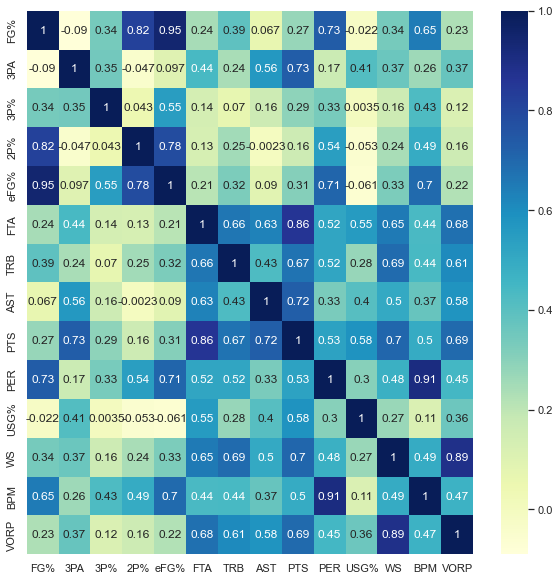

In [21]:
## Choosing the statistics to create the correlation heatmap
cols = ['FG%', '3PA','3P%', '2P%', 'eFG%', 'FTA', 'TRB', 'AST', 'PTS', 'PER', 'USG%', 'WS', 'BPM', 'VORP']
corr_df = nba_22[cols]

# Plotting the correlation heatmap on a new figure
fig2 = plt.figure(figsize =(10,10))
dataplot = sns.heatmap(corr_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

## Breaking down how the different NBA teams performed during the 2022 NBA season 

### Objective 
I want to see if we can start from individual player metrics and aggregate them in order to have a view of teamwide performance without having team win stats in our dataset


### Chosen Metrics
The only individual statistics that can be aggregated to illustrate team performance are win share statistics (OWS, DWS, WS). By summing the OWS (Offensive Win Share) of every player on a team, we get the total wins for that team coming from offense (same logic for Defensive Win Share (DWS)). By adding together OWS and DWS, we get the team's expected wins for a season. While these do not reflect the team standings for the season, they do allow us to get a holistic view of team performance for the entire season. 

### Insights drawn
<ol>
    <li>Boston and Phoenix are the most balanced teams in terms of offense and defense, and they have the most expected wins
    <li>Utah and Golden State are offensive and defensive specialists (having the top rating in the league respectively) which allows them to place in the top 5 of expected wins
    <li>We see that 7 teams in the top 10 are balanced in terms of offense and defense. One potential take-away is that if you want your team to perform at the top of the league then you should focus on creating a balanced style of play    

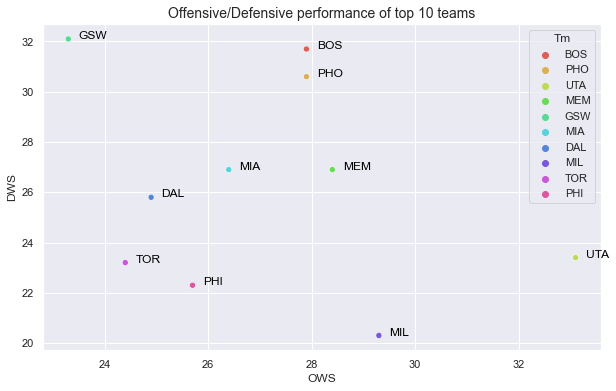

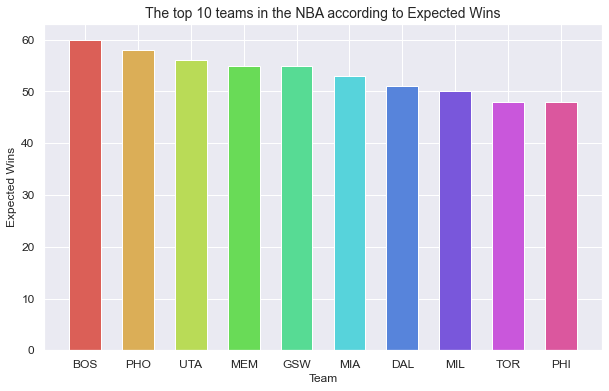

In [54]:
## Ranking the 30 NBA teams across the major statistical categories, which are WS, BPM and VORP

# Creating a dataframe to show team ranking in offensive win shares 

team_ows = nba_22[nba_22['Tm'] != 'TOT'].groupby('Tm', as_index=False)['OWS'].sum()
team_ows = pd.DataFrame(team_ows)


# Creating a dataframe to show team ranking in defensive win shares 

team_dws = nba_22[nba_22['Tm'] != 'TOT'].groupby('Tm', as_index=False)['DWS'].sum()
team_dws = pd.DataFrame(team_dws)


# Merging the two dataframes and calculating expected total wins by summing OWS and DWS

team_final = pd.merge(team_ows, team_dws, on='Tm')
team_final['Exp Wins'] = round(team_final['OWS'] + team_final['DWS'])
team_final = team_final.sort_values(by='Exp Wins', ascending=False)


# Visualizing how top 10 teams perform across offense and defense  

top_10_teams = team_final[:10]
fig4 = plt.figure(figsize = (10,6))
sns.scatterplot(data=top_10_teams, x='OWS', y='DWS', hue='Tm', palette=sns.color_palette("hls", 10), sizes=(80,80))
plt.title('Offensive/Defensive performance of top 10 teams', fontsize=14)

# label points on the plot 

for x,y,z in zip(top_10_teams['OWS'], top_10_teams['DWS'], top_10_teams['Tm']): 
    plt.text(x=x+0.2, y=y, s=z, color = 'black')

#plt.clf()
    
# Visualizing the top 10 teams in terms of expected wins 

fig_new = plt.figure(figsize=(10,6))
plt.bar('Tm','Exp Wins', data = team_final.iloc[:10], width = 0.6, color = sns.color_palette("hls", 10))
plt.ylabel('Expected Wins', fontsize=12)
plt.xlabel('Team',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('The top 10 teams in the NBA according to Expected Wins', fontsize=14)
plt.show()


## Scoring Analysis 

### Segmenting scoring by position
We want to see how scoring patterns diverge across the 5 different positions and see if we can draw some insights. Here are my take-aways
    <ol>
        <li> All of the positions have approximately the same scoring median (around 7 points per game) 
        <li> All of the positions have right-skewed scoring distributions and the guard positions have the biggest variation 
        <li> All positions have scoring outliers beyong the 1.5 IQR whisker, with the Center positions representing the most 
    </ol>
### Segmenting scoring by age
We want to see how scoring patterns diverge across different age brackets and see if we can draw some insights. Here are my take-aways. 
    <ol>
        <li> All of the age groups have approximately the same scoring median (around 6-7 points per game) 
        <li> All of the age groups have right-skewed scoring distributions, with the 24-28 group having the most variation
        <li> The U24 and 28-32 groups have the most scoring outliers while the O32 group has the most distant outliers)   
    </ol>
### Creating an aggregate measure for scoring and efficiency 
The objective here is to get an idea of who the best players in the league are at blending volume and efficiency. For that, I chose to rank players both in terms of scoring volume (by looking at points per game) and efficiency (by looking at eFG%). I chose eFG% (Effective field goal %) because it encompasses all types of field goals while disregarding free throws (which in my opinion is less revealing of a quality scor and allows us to make apples-apples comparisons across all positions. For the ranking, I applied the dedicated pandas method
<br>
In order to find the top scorers in the league, I first created a separate dataframe with minimum criteria for scoring and efficiency, as well as cutoffs for minutes played (because players with low minutes might have artificially high efficiency and average numbers). I also discarded any player with the 'TOT' team because it is a redundant row for players having been traded throughout the season.  
<br>
In order to rank players based on my subjective view of scoring productivity, which I defined to be the weighted average of scoring volume and efficiency (with an 80/20 split in favor of volume) to create the measure called 'Scoring Productivity Score'
<br> 
I then created a bar plot to visualize the top 10 most productive scorers according to my self-defined formula 


C:\Users\krist\AppData\Local\Temp\ipykernel_13148\4036511156.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['Age Group'] = nba_22.apply(lambda x: age_bracket(x['Age']),axis=1)
C:\Users\krist\AppData\Local\Temp\ipykernel_13148\4036511156.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['Scoring Rank'] = round(nba_22['PTS'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_13148\4036511156.py:35: SettingWithCopyWarning: 
A value is trying to be set on a 

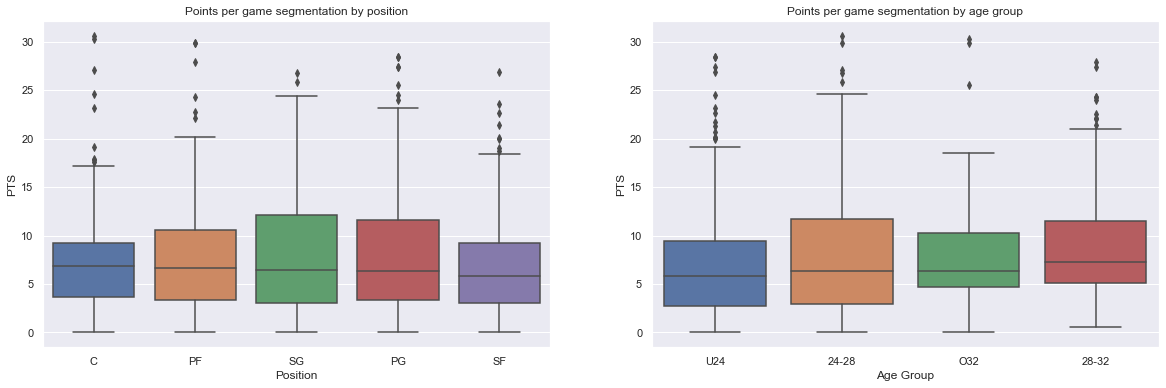

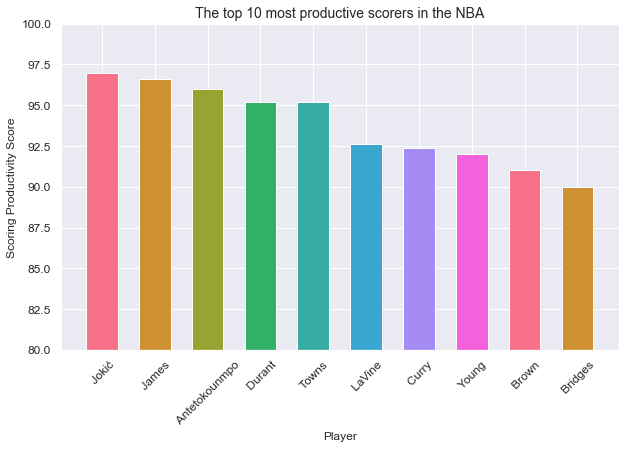

<Figure size 432x288 with 0 Axes>

In [141]:
## Breaking down scoring
    
# Segmenting scoring in the league by position and age 

# Creating the figure and axes for the first visualization 

fig5, axs = plt.subplots(1, 2, figsize=(20, 6))

# Graphing the scoring segmentation by position 
sns.boxplot(data=nba_22, x='Position',y='PTS', ax=axs[0])
axs[0].set_title('Points per game segmentation by position')

# Graphing the scoring segmentation by age 

# Bucketing age into buckets for easier visualization
def age_bracket(x):
    if x<=24: 
        return 'U24'
    elif x<=28: 
        return '24-28'
    elif x<=32: 
        return '28-32'
    else: 
        return 'O32'

nba_22['Age Group'] = nba_22.apply(lambda x: age_bracket(x['Age']),axis=1)
sns.boxplot(data=nba_22, x='Age Group',y='PTS', ax=axs[1])
axs[1].set_title('Points per game segmentation by age group')


# Determining who the most efficient scorers in the league are 

# Ranking player performance across scoring volume and efficiency
nba_22['Scoring Rank'] = round(nba_22['PTS'].rank(method='first')/len(nba_22)*100)
nba_22['Efficiency Rank'] = round(nba_22['eFG%'].rank(method='first')/len(nba_22)*100)
nba_22.head()

# Finding the top scorers who have played at least 30 minutes per game and not counting players having played with multiple teams
top_scorers = nba_22[(nba_22['Scoring Rank'] >= 95.0) & (nba_22['Efficiency Rank'] >= 60.0) & (nba_22['MP'] >= 30.0) & (nba_22['G'] >= 50) & (nba_22['Tm'] != 'TOT') ]
top_scorers['Scoring Productivity Score'] = top_scorers['Scoring Rank']*0.8 + top_scorers['Efficiency Rank']*0.2
top_scorers = top_scorers.sort_values(by='Scoring Productivity Score', ascending =False)

# Visualizing the top 10 most efficient scorers in the NBA 

fig_new = plt.figure(figsize=(10,6))
plt.bar('Player','Scoring Productivity Score', data = top_scorers.iloc[:10], width = 0.6, color = palette[:10])
plt.ylabel('Scoring Productivity Score', fontsize=12)
plt.xlabel('Player',fontsize=12)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.title('The top 10 most productive scorers in the NBA', fontsize=14)
plt.ylim(80,100)
plt.show()

plt.clf()


## Finding the top 10 most productive playmakers during the 2022 NBA season

### Defining playmaking performance
I define playmaking by considering both scoring volume (points per game) and asssits (per game). I rank players based on each metric and average both to create an aggregate playmaking metric (which I call playmaking score). 

### Dealing with duplicate player values
We note that James Harden appears twice in the rankings because he played for two teams during the season (Brooklyn and Philadelphia). I choose to deal with this duplicate value by only considering his 'TOT' season, which mixes the performance of all teams where a given player has played over the course of a season


C:\Users\krist\AppData\Local\Temp\ipykernel_13148\848458611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['Assist Rank'] = round(nba_22['AST'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_13148\848458611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['Playmaking Score'] = (nba_22['Scoring Rank'] + nba_22['Assist Rank'])/2


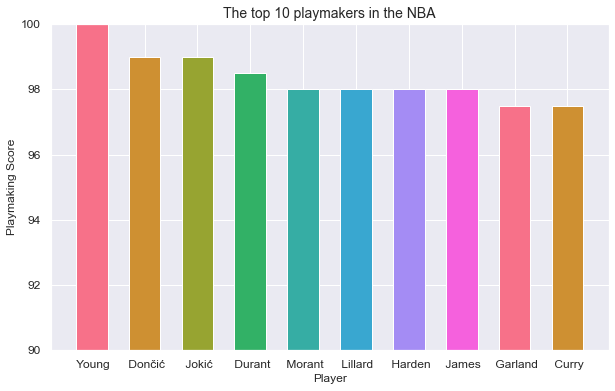

<Figure size 432x288 with 0 Axes>

In [113]:
## Finding the top 10 most productive playmakers in the league

# Ranking players on their playmaking performance by creating a dedicated playmaking score 

nba_22['Assist Rank'] = round(nba_22['AST'].rank(method='first')/len(nba_22)*100)
nba_22['Playmaking Score'] = (nba_22['Scoring Rank'] + nba_22['Assist Rank'])/2

# Getting a dataframe of the top 20 players by playmaking score  

top_playmakers = nba_22.sort_values(by='Playmaking Score', ascending =False).iloc[:20]

# Dropping the duplicate player values, in this case James Harden
top_playmakers = top_playmakers.drop_duplicates(subset='Player',keep='last')

fig8 = plt.figure(figsize=(10,6))
plt.bar('Player','Playmaking Score', data = top_playmakers.iloc[:10], width = 0.6, color = palette[:10])
plt.ylabel('Playmaking Score', fontsize=12)
plt.xlabel('Player',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('The top 10 playmakers in the NBA', fontsize=14)
plt.ylim(90,100)
plt.show()

plt.clf()



## Finding the most productive 3-point shooters during the 2022 NBA season

### Defining 3-point shooting productivity
I simply define 3-point point shooting productivity as a mix between volume (3PA) and efficiency (3P%). In terms of method, I ranked each player in the league in terms of both metrics and then I created an aggregate '3P Productivity Score', which is a weighted average (with 50/50 weights assigned) volume and efficiency. Having this aggregate metrics in hand allows me to then plot the most productive 3-point shooters in the league. 


C:\Users\krist\AppData\Local\Temp\ipykernel_13148\4093847142.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['3P% Rank'] = round(nba_22['3P%'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_13148\4093847142.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['3PA Rank'] = round(nba_22['3PA'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_13148\4093847142.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

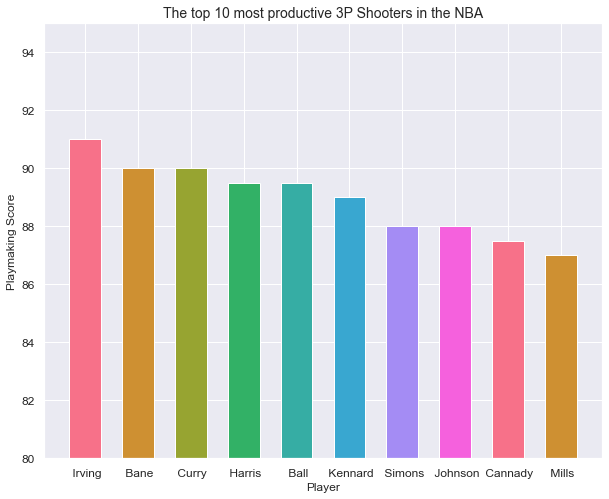

<Figure size 432x288 with 0 Axes>

In [119]:
## Breaking down three-point shooting performance  


# Ranking players on their shooting performance by creating a dedicated score 

nba_22['3P% Rank'] = round(nba_22['3P%'].rank(method='first')/len(nba_22)*100)
nba_22['3PA Rank'] = round(nba_22['3PA'].rank(method='first')/len(nba_22)*100)
nba_22['3P Productivity Score'] = (nba_22['3P% Rank'] + nba_22['3PA Rank'])/2

#Finding the top 10 shooting for the 2022 season  
top_shooters = nba_22.sort_values(by='3P Productivity Score', ascending =False)

fig9 = plt.figure(figsize=(10,8))
plt.bar('Player','3P Productivity Score', data = top_shooters.iloc[:10], width = 0.6, color = palette[:10])
plt.ylabel('Playmaking Score', fontsize=12)
plt.xlabel('Player',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('The top 10 most productive 3P Shooters in the NBA', fontsize=14)
plt.ylim(80,95)
plt.show()

plt.clf()

## Finding the most productive defenders during the 2022 NBA season
### Defining defensive performance 
I used 4 metrics to define defensive productivity: 2 aggregate measures (DWS and DBPM) and 2 specific measures (STL% and BLK%). 
<br>
I chose DWS and DBPM to convey 'big picture' defensive impact and STL%/BLK% to convey a more specific and direct measure of defensive impact (DWS and DBPM can be heavily influenced by team play and thus artifically boost a player's stats in these categories). As such, STL%/BLK% complement the other stats while giving us a way to filter out players who don't have high production in individual defensive stats. 
<br>
I ranked players across all 4 categories, then filtered the league for players matching minimum characteristics across all 4 measures (meeting 80th percentile for both aggregate measures and meeting 90th percentile in either steals or blocks, because steals favor guards and wings while blocks favor big men, so we want to create parity before calculating the final defense score. 
<br>
I created the aggregate 'Defense Score' metric by simply averaging a player's DWS and DBPM score. This allows me to then plot each player's performance in a box plot to visualize who the 10 most productive defenders in the league are

C:\Users\krist\AppData\Local\Temp\ipykernel_13148\1576140079.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['DWS Rank'] = round(nba_22['DWS'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_13148\1576140079.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['DBPM Rank'] = round(nba_22['DBPM'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_13148\1576140079.py:6: SettingWithCopyWarning: 
A value is trying to be set on a c

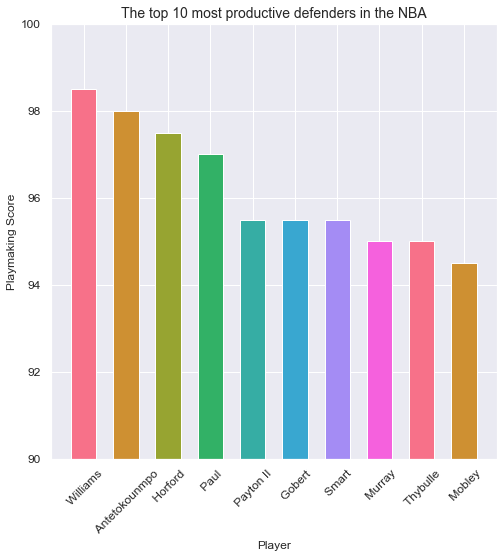

<Figure size 432x288 with 0 Axes>

In [124]:
## Breaking down defense 

# assigning top decile performance across the chosen categories of defense, which are DWS and DBPM
nba_22['DWS Rank'] = round(nba_22['DWS'].rank(method='first')/len(nba_22)*100)
nba_22['DBPM Rank'] = round(nba_22['DBPM'].rank(method='first')/len(nba_22)*100)
nba_22['STL% Rank'] = round(nba_22['STL%'].rank(method='first')/len(nba_22)*100)
nba_22['BLK% Rank'] = round(nba_22['BLK%'].rank(method='first')/len(nba_22)*100)

#Finding the top defenders in the league  
top_defenders = nba_22[(nba_22['DWS Rank'] >= 80.0) & (nba_22['DBPM Rank'] >= 80.0) & ((nba_22['STL% Rank'] >= 90.0)|(nba_22['BLK% Rank'] >= 90.0))]
top_defenders['Defense Score'] = (top_defenders['DWS Rank'] + top_defenders['DBPM Rank'])/2
top_defenders = top_defenders.sort_values(by='Defense Score', ascending =False)

#Visualizing the top defenders using a simple plt plot 
fig10 = plt.figure(figsize=(8,8))
plt.bar('Player','Defense Score', data = top_defenders.iloc[:10], width = 0.6, color = palette[:10])
plt.ylabel('Playmaking Score', fontsize=12)
plt.xlabel('Player',fontsize=12)
plt.xticks(fontsize=12, rotation = 45)
plt.yticks(fontsize=12)
plt.title('The top 10 most productive defenders in the NBA', fontsize=14)
plt.ylim(90,100)
plt.show()


plt.clf()


## Finding out who are the league's most productive players
### Defining player productivity 
I took the simple approach of simply taking the 4 aggregate measures of player efficiency, ranking players on each one and then taking the average of each to create an aggregate 'Productivity Score'. This productivity score is then used to plot the 10 most productive players in the league. 


C:\Users\krist\AppData\Local\Temp\ipykernel_13148\1252761523.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['PER Rank'] = round(nba_22['PER'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_13148\1252761523.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_22['BPM Rank'] = round(nba_22['BPM'].rank(method='first')/len(nba_22)*100)
C:\Users\krist\AppData\Local\Temp\ipykernel_13148\1252761523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a cop

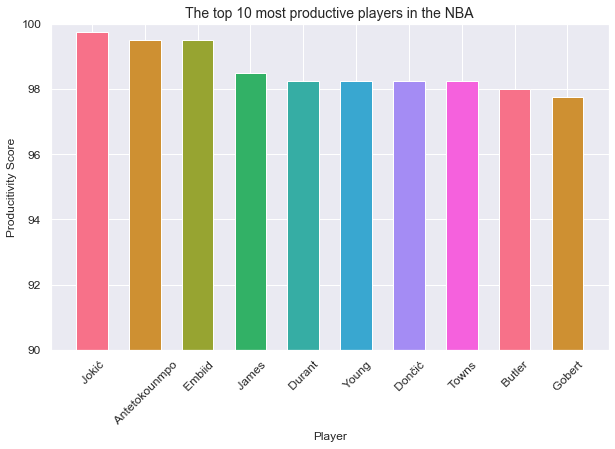

In [140]:
## In-depth breakdown of the league's most productive players, using aggregate statistics such as PER, BPM, WS and VORP 

# assigning top decile performance across the chosen categories of defense, which are DWS and DBPM
nba_22['PER Rank'] = round(nba_22['PER'].rank(method='first')/len(nba_22)*100)
nba_22['BPM Rank'] = round(nba_22['BPM'].rank(method='first')/len(nba_22)*100)
nba_22['WS Rank'] = round(nba_22['WS'].rank(method='first')/len(nba_22)*100)
nba_22['VORP Rank'] = round(nba_22['VORP'].rank(method='first')/len(nba_22)*100)

#Finding the top defenders in the league  
top_players = nba_22[(nba_22['PER Rank'] >= 80.0) & (nba_22['BPM Rank'] >= 80.0) & (nba_22['WS Rank'] >= 80.0) & (nba_22['VORP Rank'] >= 80.0) & (nba_22['MP'] >= 32.0)]
top_players['Productivity Score'] = (top_players['PER Rank'] + top_players['BPM Rank'] + top_players['WS Rank'] + top_players['VORP Rank'])/4
top_players = top_players.sort_values(by='Productivity Score', ascending =False)

#Visualizing the top defenders using a simple plt plot 
fig11 = plt.figure(figsize=(10,6))
plt.bar('Player','Productivity Score', data = top_players.iloc[:10], width = 0.6, color = palette[:10])
plt.ylabel('Producitivity Score', fontsize=12)
plt.xlabel('Player',fontsize=12)
plt.xticks(fontsize=12, rotation = 45)
plt.yticks(fontsize=12)
plt.title('The top 10 most productive players in the NBA', fontsize=14)
plt.ylim(90,100)
plt.show()
